In [116]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [117]:
from useful_functions import *

## Score constituencies

In [118]:
election_results = read_in_election_results() 

In [119]:
#Pick year of interest
year = 19 # 2019 election
compare_year = 17

In [120]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)
diff = score_campaigns_difference(election_results[year], 
                                     election_results[compare_year])
uns  = score_campaigns_uns(election_results[year], 
                              election_results[compare_year])
mrp  = score_campaigns_mrp(election_results[year])

In [131]:
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], diff['difference'],uns['difference'],mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.194483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.155008,0.066410
E14000958,Southport,0.389518,3140.0,0.142657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.124321,-0.003605
E14000887,Putney,0.451384,3655.0,0.122549,0.111384


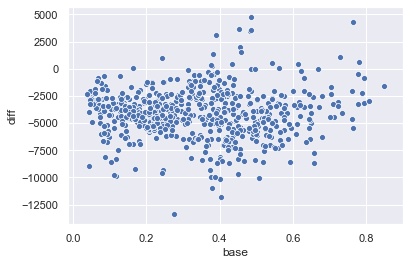

In [13]:
sns.scatterplot(scores['base'],scores['diff'])

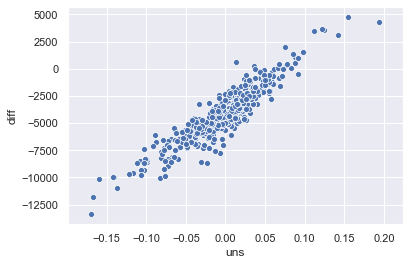

In [10]:
sns.scatterplot(scores['uns'],scores['diff'])

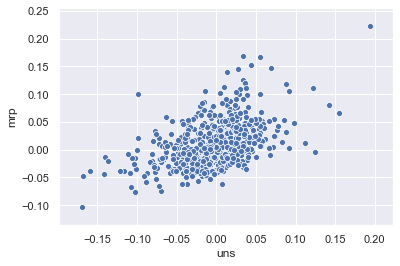

In [8]:
sns.scatterplot(scores['uns'],scores['mrp'])

In [19]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,election_results[compare_year])

## Select demographic data to compare constituencies

In [20]:
census = read_in_census()
print(len(census))
# only want rows we have election data for
census = census.loc[election_results[year].index]
print(len(census))

650
650


In [21]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [28]:
demographic_data = census[features]

In [30]:
# a list of constituencies we have complete data for

demographic_data = demographic_data.dropna()
# Speaker seats have incomplete voting data
demographic_data = demographic_data.drop([onsid_from_name('Chorley',election_results[year]),
                                          onsid_from_name('Buckingham',election_results[year])])

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [32]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = [name_from_onsid(i,election_results[year]) for i in constits_id]

scores = scores.loc[constits_id] # only interested in these constits now

constits_onsid_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
constits_name_to_index = {name:i for i,name in enumerate(constits_name)}

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency base on their demographics. Similar constituencies, based on the features chosen above' will have a small distance between them.

We then calculate the relative score between each campaign.

This score is divided by the distance for each constituency. Our confidence in this constituencies campaing is the sum of this value for all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [34]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

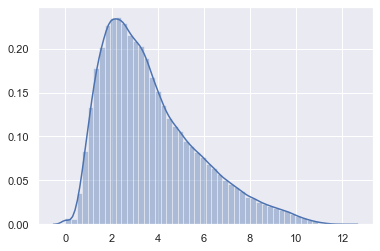

In [47]:
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
sns.distplot(np.ndarray.flatten(dist_matrix))

In [48]:
scores['Constituency'].iloc[np.where(dist_matrix == np.max(dist_matrix))[0]]

ons_id
E14000638           Christchurch
E14000555    Bethnal Green & Bow
Name: Constituency, dtype: object

In [81]:
def distance(X, cutoff=None):
    return pairwise_distances(X)

def distance_rescale_simple(X, cutoff):
    dist_matrix = distance(X)
    mask = dist_matrix > cutoff
    dist_matrix[mask] = 0
    return dist_matrix

def distance_rescale(X, cutoff):
    dist_matrix = distance(X)
    n = len(dist_matrix)
    for i in range(n):
        for j in range(n):
            if 0 < dist_matrix[i][j] < cutoff:
                dist_matrix[i][j] = 1 / (cutoff - dist_matrix[i][j])
            else: 
                dist_matrix[i][j] = 0
    return dist_matrix

def calc_significance_matrix(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    X_scaled      = preprocessing.scale(demographic_data)
    dist_matrix   = dist_func(X_scaled,cutoff)
    constit_score = preprocessing.scale(constit_score)
    score_matrix  = constit_score[:,np.newaxis] - constit_score
    significance  = np.zeros(score_matrix.shape) # need to initialise all to zero
    significance  = np.divide( score_matrix, dist_matrix, where=dist_matrix!=0)
    return significance
    
def calc_campaign_conf(demographic_data, constit_score, 
                             dist_func=distance, cutoff=None):
    assert np.all( demographic_data.index == constit_score.index )
    significance = calc_significance_matrix(demographic_data, constit_score, dist_func, cutoff)
    return pd.Series(np.sum(significance,1),index=constits_id)

In [82]:
base = calc_campaign_conf(demographic_data, scores['base'])
diff = calc_campaign_conf(demographic_data, scores['diff'])
uns = calc_campaign_conf(demographic_data, scores['uns'])
mrp = calc_campaign_conf(demographic_data, scores['mrp'])

In [83]:
cutoff = 2
base_cut = calc_campaign_conf(demographic_data, scores['base'],distance_rescale_simple, cutoff)
diff_cut = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale_simple, cutoff)
uns_cut  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale_simple, cutoff)
mrp_cut  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale_simple, cutoff)

In [84]:
cutoff = 2
base_rescale = calc_campaign_conf(demographic_data, scores['base'],distance_rescale, cutoff)
diff_rescale = calc_campaign_conf(demographic_data, scores['diff'],distance_rescale, cutoff)
uns_rescale  = calc_campaign_conf(demographic_data, scores['uns'],distance_rescale, cutoff)
mrp_rescale  = calc_campaign_conf(demographic_data, scores['mrp'],distance_rescale, cutoff)

In [85]:
results = pd.DataFrame({'constituency': constits_name,
                        'base':base, 'diff': diff, 'uns': uns, 'mrp': mrp,
                        'base_cut':base_cut,'diff_cut': diff_cut, 'uns_cut': uns_cut, 'mrp_cut': mrp_cut,
                        'base_rescale':base_rescale,'diff_rescale': diff_rescale, 'uns_rescale': uns_rescale, 'mrp_rescale': mrp_rescale},
                       index = constits_id)
results.head(10)

,constituency,base,diff,uns,mrp,base_cut,diff_cut,uns_cut,mrp_cut,base_rescale,diff_rescale,uns_rescale,mrp_rescale
ons_id,,,,,,,,,,,,,
E14000754,Houghton & Sunderland South,68.552682,-387.278726,-512.004951,-284.190487,9.007979,-107.163737,-145.078512,-102.450889,3.205347,-75.912667,-103.665430,-79.186047
E14000831,Newcastle upon Tyne Central,130.505344,93.114382,18.468009,24.674054,-0.203807,2.356503,0.960139,-1.923710,-0.374342,0.991928,0.055642,-1.434535
E14000832,Newcastle upon Tyne East,120.764127,82.320647,5.544861,-11.311066,-0.342166,0.136881,-1.038440,-2.157829,-0.066107,-0.312368,-0.708144,-0.453817
E14000833,Newcastle upon Tyne North,173.025390,-114.434877,-85.233361,-140.064474,71.734217,-30.858511,-7.964993,-53.801290,49.297599,-14.578206,1.742529,-39.913080
E14000982,Sunderland Central,48.795385,-189.342902,-206.437289,-236.915234,-14.390159,-20.821328,-21.617672,-62.487714,-9.170254,-9.796786,-10.161982,-35.085974
E14001020,Washington & Sunderland West,69.238763,-393.894068,-465.157498,-189.502785,-3.017507,-98.487850,-113.511384,-70.619364,-5.805580,-62.351257,-72.332250,-51.279020
E14000725,Halton,401.900336,-236.074999,-14.274185,497.747163,176.137447,-68.117430,56.286550,264.952703,127.094520,-37.545230,56.444889,197.092487
E14000544,Basildon & Billericay,-217.827641,-48.591255,-120.414554,-119.347452,-143.328084,-0.509532,-37.163453,-49.081394,-111.928149,6.377600,-22.375613,-33.792722
E14000606,Broxbourne,-144.385927,167.655691,157.502790,120.961509,-74.185988,107.342153,102.266831,93.844399,-52.058048,72.420940,67.848162,66.506233


In [86]:
from sklearn.metrics import r2_score


use MRP score as reference

In [89]:
r2_score(
    preprocessing.scale(scores['mrp']),
    preprocessing.scale(results['uns_rescale'])
)

-0.371195120981199

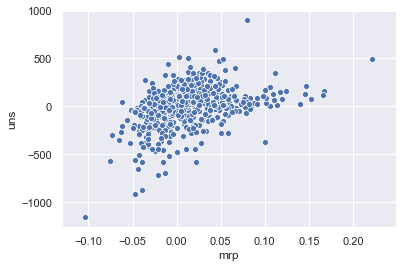

In [90]:
sns.scatterplot(x=scores['mrp'],
                y=results['uns'])

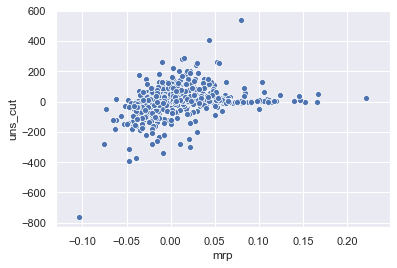

In [91]:
sns.scatterplot(x=scores['mrp'], y=results['uns_cut'])

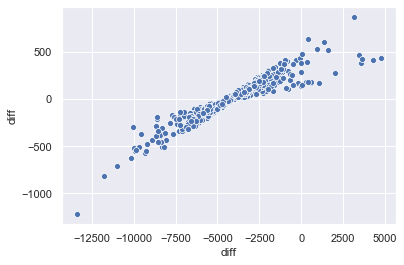

In [124]:
sns.scatterplot(x=scores['diff'], y=results['diff'])

In [130]:
results.sort_values('diff_rescale',ascending=False).head(20)

,constituency,base,diff,uns,mrp,base_cut,diff_cut,uns_cut,mrp_cut,base_rescale,diff_rescale,uns_rescale,mrp_rescale
ons_id,,,,,,,,,,,,,
E14000958,Southport,107.450759,873.391995,903.445590,508.908821,78.753332,516.945502,540.438908,325.261522,54.757754,375.011547,392.178139,239.310799
W07000078,Vale of Glamorgan,191.224299,640.383662,583.702238,308.269487,140.161314,442.816753,408.567822,238.488475,99.084329,339.743434,314.235261,183.630328
E14000961,St Austell & Newquay,-73.809848,418.940918,382.325752,388.381844,-21.185273,272.048279,253.986796,283.424271,-14.022202,196.906857,185.027950,212.006132
E14000743,Hereford & Herefordshire South,-165.126222,387.534767,410.171578,98.565503,-86.037850,269.377964,286.641758,98.985845,-65.156272,196.091757,208.659739,78.306725
E14001003,Truro & Falmouth,109.346923,601.605985,493.941802,308.757604,98.005042,321.683486,260.767112,196.152118,61.390415,194.816873,156.908034,122.663453
W07000063,Montgomeryshire,-195.820416,479.969289,504.206036,75.723244,-71.676611,268.892804,284.123287,73.879859,-46.572280,191.676626,202.470706,55.765963
E14000682,Worthing East & Shoreham,95.726851,383.327774,386.426919,194.296393,98.288265,254.297164,256.446796,161.389825,68.320043,190.262165,191.490936,122.859507
E14000925,Shipley,142.736398,345.404029,315.208586,139.238332,141.580037,226.769104,199.149637,122.463052,101.286298,167.541954,146.257654,88.354377
E14000684,Eastbourne,-387.121140,402.441195,436.097881,-93.118872,-208.438579,235.029464,261.458267,-21.527350,-147.224571,167.354182,186.567371,-14.620587


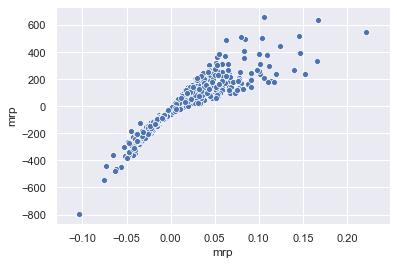

In [94]:
sns.scatterplot(scores['mrp'],results['mrp'])

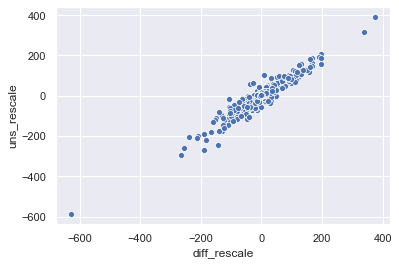

In [113]:
sns.scatterplot(results['diff_rescale'],results['uns_rescale'])

This cell is ment to plot constituencies by demographics, then draw lines between constits that contribute to its result.

-3.176319684548798 Canterbury
1.6917855019760208 Durham, City of
-1.3573883859539793 Leeds North West
1.1175693358443644 Bassetlaw
1.0147668995431374 Wentworth & Dearne


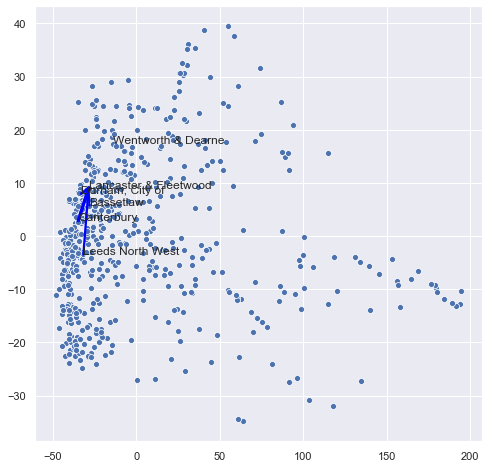

In [105]:
#centre = 'Ellesmere Port & Neston'
centre = 'Lancaster & Fleetwood'

significance_matrix = calc_significance_matrix(demographic_data, scores['uns'])
centre_i = constits_name_to_index[centre]
contributions = significance_matrix[centre_i]

# coi = constits of interest
coi   = [onsid_from_name(centre,election_results[year])]
linexs = []
lineys = []
values = []

N = 5
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    coi += [onsid]
    values += [contributions[i]]
    print(contributions[i],name_from_onsid(onsid,election_results[year]))

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)

X = demographic_data#[mask]
X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in coi:
    linexs += [ [x[centre_i],x[constits_onsid_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[constits_onsid_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value*2, color='blue')

val = pd.Series([name_from_onsid(i,election_results[year]) for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
for c in coi:
    ax.text(x[constits_onsid_to_index[c]], y[constits_onsid_to_index[c]], name_from_onsid(c,election_results[year]))
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [ ]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

## Cluster

In [106]:
from sklearn import cluster, covariance, manifold
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
X = demographic_data
X_scaled = preprocessing.scale(X)

clustering = AffinityPropagation(verbose=True).fit(X)

Converged after 34 iterations.


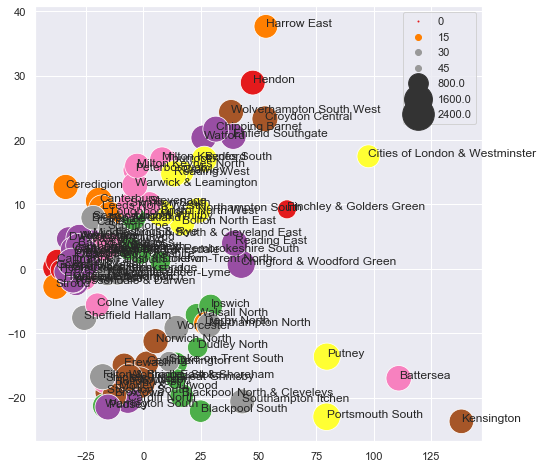

In [110]:
X = demographic_data.loc[marginals]
sizes = results['uns'].loc[marginals]
sizes = np.array(sizes) - min(sizes)
hues = list(pd.Series(clustering.labels_,index=results.index)[marginals])

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

embedding = Isomap(n_components=2)

X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
label = pd.Series([name_from_onsid(i,election_results[year]) for i in X.index])
label.index=range(len(X_transformed))

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y,
                     size=sizes, sizes=(1, 1000),
                     hue=hues, palette='Set1')
a = pd.concat({'x': x, 'y': y, 'label': label}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['label']))


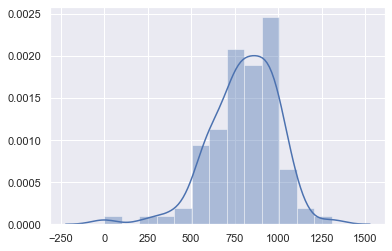

In [109]:
sns.distplot(sizes)